# Importing the dataset

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
filepath = '/content/drive/MyDrive/dataset_proyecto3.csv'
df  = pd.read_csv(filepath)

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,simple_toxic
0,5f140a8f41763bad,"""== A barnstar for you! ==\r\n\r\n The Minor ...",0,0,0,0,0,0,0
1,c57b608d96f057f2,"""==Glenn Beck Hoax==\r\nThis topic should be d...",0,0,0,0,0,0,0
2,1d9867f0f60ba9bd,"""\r\n\r\n Date of establishment \r\n\r\nCharle...",0,0,0,0,0,0,0
3,17eb2a66bfce1023,==AfD nomination of Untitled Chilli Album== \r...,0,0,0,0,0,0,0
4,b8324615a1bcaf58,scum who look up to Che deserve the worst kind...,1,0,1,1,1,0,1


#Preprocess

In [5]:
from tensorflow.keras.layers import TextVectorization

In [6]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [7]:
MAX_FEATURES = 200000 # number of words in the vocab

In [8]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [9]:
vectorizer.adapt(X.values)

In [10]:
vectorized_text = vectorizer(X.values)

In [11]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [12]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# Create LSTM

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [14]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='sigmoid'))

In [15]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 7)                 903       
                                                        

In [17]:
history = model.fit(train, epochs=2, validation_data=val)

Epoch 1/2
978/978 [==============================] - 1499s 2s/step - loss: 0.1240 - val_loss: 0.0757
Epoch 2/2
978/978 [==============================] - 1496s 2s/step - loss: 0.0648 - val_loss: 0.0531


In [18]:
from matplotlib import pyplot as plt

In [36]:
history.history

{'loss': [0.12400606274604797, 0.06483781337738037],
 'val_loss': [0.07568372040987015, 0.053078725934028625]}

<Figure size 576x360 with 0 Axes>

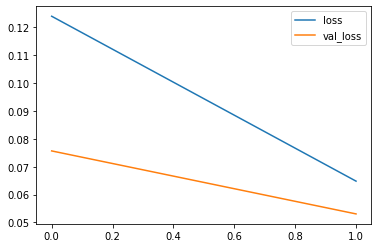

In [19]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

#Make Predictions

In [20]:
input_text = vectorizer(['You freaking suck! I am going to hit you.'])

In [21]:
res = model.predict(input_text)

In [22]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0, 1]])

#Tests

In [23]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [24]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [25]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [26]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.842276394367218, Recall:0.7125172019004822, Accuracy:0.028776979073882103


In [27]:
import tensorflow as tf

In [28]:
model.save('toxicity.h5')

In [29]:
model = tf.keras.models.load_model('toxicity.h5')

In [30]:
input_str = vectorizer('hello!')

In [31]:
res = model.predict(np.expand_dims(input_str,0))

In [32]:
res

array([[0.02778617, 0.0001924 , 0.01172101, 0.00157911, 0.00272673,
        0.00131363, 0.02844271]], dtype=float32)

In [33]:
input_str = vectorizer('fuck you!')

In [34]:
res = model.predict(np.expand_dims(input_str,0))

In [35]:
res

array([[0.93438506, 0.23309994, 0.80016196, 0.03285587, 0.7649443 ,
        0.17345846, 0.9414941 ]], dtype=float32)